In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import functions

from lambeq import BobcatParser

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['KMP_DUPLICATE_LIB_OK']='True'



In [2]:
## IMDB set

## Process data, split into training/test
imdb_data = pd.read_csv('IMDB Dataset.csv')
## My PC is weak as fuck so truncate Dataset
imdb_data = imdb_data[1:1000]
size = int(len(imdb_data)*0.8)
imdb_training = imdb_data.loc[:size].copy()
imdb_testing = imdb_data.loc[size:].copy()

## convert to numpy array
train, trainlabels = imdb_training.iloc[:,0].to_numpy(), imdb_training.iloc[:,1].to_numpy()
test, testlabels = imdb_testing.iloc[:,0].to_numpy(), imdb_testing.iloc[:,1].to_numpy()


In [3]:
## Twitter dataset
negative = np.loadtxt("processedNegative.csv", delimiter=",", dtype = str).reshape(-1,1)
neglabels = np.full(np.shape(negative),-1)
neutral = np.loadtxt("processedNeutral.csv", delimiter=",", dtype = str).reshape(-1,1)
neutlabels = np.full(np.shape(neutral),0)
positive = np.loadtxt("processedPositive.csv", delimiter=",", dtype = str).reshape(-1,1)
poslabels = np.full(np.shape(positive),1)

negset = np.concatenate((negative,neglabels), axis=1)
neutset = np.concatenate((neutral,neutlabels), axis=1)
posset =  np.concatenate((positive,poslabels), axis=1)

dataset = np.concatenate((negset,neutset,posset), axis=0)

np.random.shuffle(dataset)
print(len(dataset))

3873


In [4]:
sentences = [] 
labels =[]
for i in dataset:
    sentences.append(i[0])
    labels.append(i[1])

ratio = 0.8
size = int(len(dataset)*ratio)
train_data, train_labels = sentences[1:10], labels[1:10]
val_data, val_labels = sentences[1:10], labels[1:10]


In [5]:
## Convert sentences to circuits w lambeq
parser = BobcatParser(root_cats=('NP','N'),verbose = 'text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [6]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

In [14]:
from lambeq import AtomicType, IQPAnsatz, remove_cups
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
PUNC = AtomicType.PUNCTUATION
C = AtomicType.CONJUNCTION

ansatz = IQPAnsatz({N: 1,S: 0, P: 1, PUNC: 0, C: 0},
                   n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

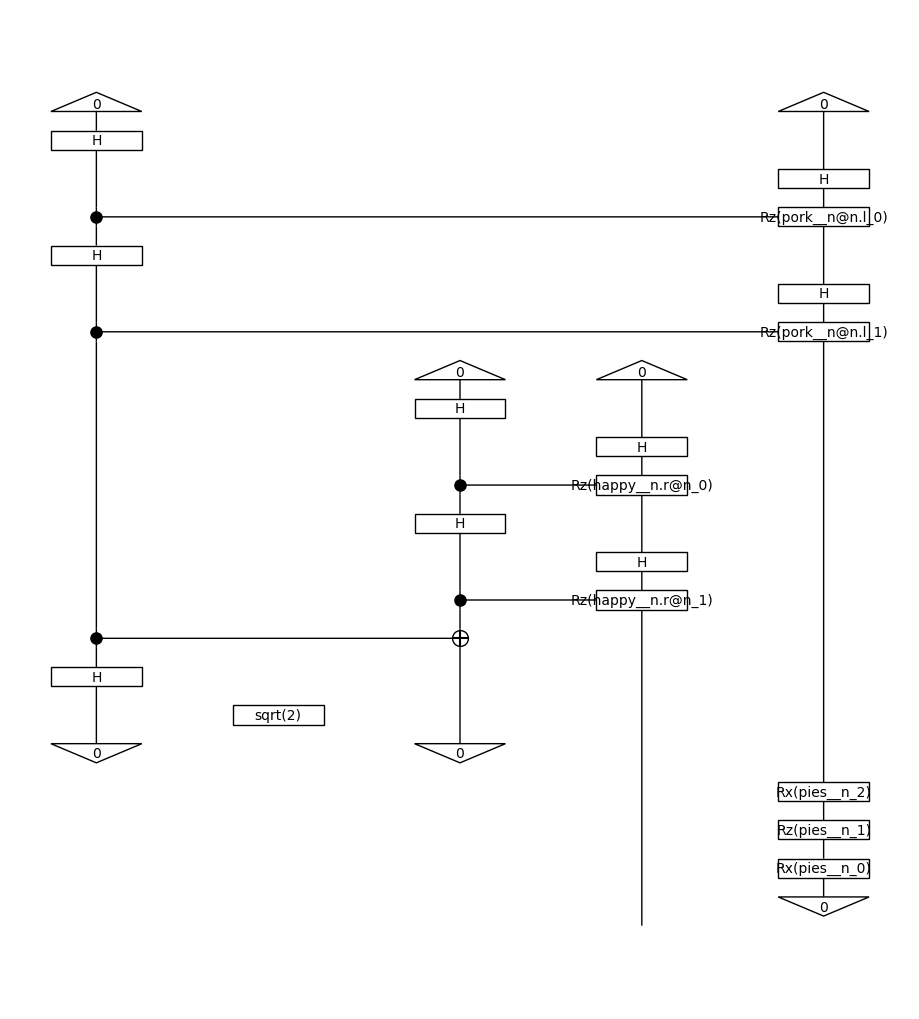

In [17]:
train_circuits[5].draw(figsize=(9, 10))

In [ ]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = discopy_circuit.to_tk()

render_circuit_jupyter(tket_circuit)